In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time
from collections import defaultdict
from scipy.spatial import distance
import pickle
from tqdm import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
cd /content/drive/MyDrive/Colab_Notebooks/WSTM project

/content/drive/MyDrive/Colab_Notebooks/WSTM project


In [5]:
user_emb = pd.read_pickle(r'embeddings/user.pickle')

In [6]:
len(user_emb)

267821

In [7]:
item_emb = pd.read_pickle(r'embeddings/item.pickle')

In [8]:
len(item_emb)

36182

In [9]:
user_emb['0']

array([0.288239  , 0.37552256, 0.31567088, 0.28592683, 0.22263737,
       0.33746718, 0.22935844, 0.466421  , 0.50259061, 0.2012313 ,
       0.41333611, 0.27794046, 0.2973072 , 0.48494148, 0.03980874])

In [10]:
user_items_ratings_df = pd.read_csv("user_item_ratings.csv")

In [11]:
# user_items_ratings_df

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# user_items_ratings_df

In [14]:
X = user_items_ratings_df

In [15]:
y = user_items_ratings_df["rating"]

In [16]:
training_data, test_data, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

In [17]:
# training_data

In [18]:
class MLP(nn.Module):
    def __init__(self):
        """
        Arguments: 
        self: the MLP model class.

        Steps:
        1. define the first hidden layer (self.fc1) with size of [64,512] (use nn.Linear()).
        2. define the second hidden layer (self.fc2) with size of [512,512] (use nn.Linear()).
        3. define the output layer (self.output) with size of [512,1] (use nn.Linear()).
        4. define the ReLU activation layer (use nn.ReLU() with default hyperparameters). 
            - Please use one ReLU layer for the MLP model, instead of using multiple ReLU layers.
        """
        
        torch.manual_seed(0)
        np.random.seed(0)
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(30,512)
        self.fc2 = nn.Linear(512,512)
        self.output = nn.Linear(512,1)
        self.relu = nn.ReLU()


        #################################

    def forward(self, input_emb):
        """
        Arguments: 
        self: the MLP model class.
        input_emb: the input data which is a concatenation of user and item embeddings.
      
        Returns:
        prediction (torch.FloatTensor): the prediction values (torch.FloatTensor format) for a given input.

        Steps:
        1. compute the first intermediate output by feeding the input_emb to the first hidden layer (self.fc1) and applying ReLU activation.
        2. compute the second intermediate output by feeding the first intermediate output to the second hidden layer (self.fc2) and applying ReLU activation. 
        3. compute the prediction values by feeding the second intermediate output to the output layer (self.output) and applying ReLU activation.
        4. return the prediction values.
        """
        input_emb = input_emb.cuda()
        x = self.fc1(input_emb)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.output(x)
        output = self.relu(x)
        # output = output.cpu().detach().numpy()
        output = output.cpu()

        #################################
        return output

In [19]:
torch.cuda.set_device(0)

In [20]:
MLP_model = MLP()
MLP_model.cuda()
MLP_model

MLP(
  (fc1): Linear(in_features=30, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
)

In [23]:
!pip  install torchinfo

In [24]:
from torchinfo import summary

In [25]:
summary(MLP_model)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            15,872
├─Linear: 1-2                            262,656
├─Linear: 1-3                            513
├─ReLU: 1-4                              --
Total params: 279,041
Trainable params: 279,041
Non-trainable params: 0

In [26]:
l = []
for index, row in training_data.iterrows():
    # print(row['user_id_csv'], row['book_id'])
    user = row['user_id_csv']
    item = row['book_id']
    # print(user)
    user_emb_of_u = user_emb[str(user)]
    item_emb_of_i = item_emb[str(item)]
    l.append(np.concatenate((user_emb_of_u,item_emb_of_i)))

In [27]:
embed = {'embs': l}

In [28]:
embed_df = pd.DataFrame(embed)

In [29]:
embed_df

,embs
0,"[0.17882422278277788, 0.30080358709043803, 0.2..."
1,"[0.3156478800603882, 0.37526935453331217, 0.37..."
2,"[0.22421035066611902, 0.503988074252769, 0.078..."
3,"[0.26645679868730165, 0.053394326116568955, 0...."
4,"[0.5034767933220732, 0.36125810696370303, 0.35..."
...,...
1106148,"[0.2560729035935654, 0.198293305331697, 0.2486..."
1106149,"[0.0660283275469795, 0.31634199002844743, 0.47..."
1106150,"[0.4614407893618341, 0.3292817657944404, 0.225..."
1106151,"[0.38995256542132445, 0.5089475951472061, 0.59..."


In [30]:
# embed_df.to_csv("combined_embeddings_train.csv",index = False)

In [31]:
MAE_list = []
MSE_list = []
RMSE_list = []

In [32]:
def MLP_train(training_data,user_emb,item_emb,MLP_model,epochs=15):
    """
    Arguments: 
    training_data (str-type numpy.array): the training data containing user_id, movie_id, and normalized rating (0-1) information.
    user_emb and item_emb (dictionaries of numpy.array): pre-trained embeddings of users and items. 
    - The keys are user_id (string) and item_id (string), and the values are the corresponding embeddings (numpy.array; dim=32) of user_id and item_id, respectively.
    MLP_model (MLP class): the untrained MLP model.
    epochs (int): number of iterations required for updating the MLP model.

    Returns:
    MLP_model (MLP class): the MLP model trained with given training data and pre-trained embeddings.

    Steps for the first code block:
    1. for each training example, retrieve pre-trained embeddings for a user u and item i.
    2. concatenate those embeddings by np.concatenate((user_emb_of_u,item_emb_of_i)) and append it to a list.
    3. convert a list of concatenated embeddings to a PyTorch FloatTensor by torch.FloatTensor(np.array(list)).
    """
    torch.manual_seed(0)
    np.random.seed(0)

  # l = []
  # for row in training_data:
  #   # print(row)
  #   user = row[0]
  #   item = row[1]
  #   user_emb_of_u = user_emb[user]
  #   item_emb_of_i = item_emb[item]
  #   l.append(np.concatenate((user_emb_of_u,item_emb_of_i)))

   
    input_data = torch.FloatTensor(np.array(l))

    
  #################################
  
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(MLP_model.parameters())

    for epoch in tqdm(range(epochs)):
        """  
    Steps for the second code block:
    1. set the gradients to zero before backpropragation by optimizer.zero_grad().
    2. call the prediction function of the MLP model by MLP_model(input_data).flatten() and obtain the prediction result for the input data, 
       where the input data is a PyTorch FloatTensor from Step 3 of the previous code block.
    3. obtain the ground-truth rating values from training_data (in torch.FloatTensor format; use torch.FloatTensor(np.array) for type conversion).
    4. compute the loss by loss=criterion(prediction,ground_truth).
    5. perform backpropragation by loss.backward().
    6. update the model parameters by optimizer.step().
    7. compute the differences between the prediction and ground_truth by (prediction-ground_truth).detach().numpy().
    8. compute and print training RMSE using the differences for every 10 epochs (epoch 0, epoch 10, ..., epoch 190).
        - Don't use loss in Step 4 to derive training RMSE 
        """
        optimizer.zero_grad()
        prediction = MLP_model(input_data).flatten()
        ground_truth = torch.FloatTensor(np.array(training_data['rating']).astype(np.float32).reshape(len(training_data)))

        loss = criterion(prediction,ground_truth)
        loss.backward()
        optimizer.step()

        diff = (prediction-ground_truth).detach().numpy()
        rmse = (np.sum(diff**2)/len(training_data))**0.5

        abs_diff = np.absolute(diff)
        mae = np.mean(abs_diff)
        # if epoch % 10 == 0:
        print("rmse:", rmse, "mse:",loss, "mae:",mae)
        MAE_list.append(mae)
        MSE_list.append(loss)
        RMSE_list.append(rmse)
            
    #################################
    return MLP_model

In [33]:
trained_MLP_model = MLP_train(training_data,user_emb,item_emb,MLP_model)

  7%|▋         | 1/15 [00:00<00:09,  1.50it/s]

rmse: 4.162001285095312 mse: tensor(17.3223, grad_fn=<MseLossBackward0>) mae: 4.0454855


 13%|█▎        | 2/15 [00:01<00:13,  1.02s/it]

rmse: 3.6898642866412485 mse: tensor(13.6151, grad_fn=<MseLossBackward0>) mae: 3.5584028


 20%|██        | 3/15 [00:03<00:14,  1.17s/it]

rmse: 3.218568982795485 mse: tensor(10.3592, grad_fn=<MseLossBackward0>) mae: 3.065036


 27%|██▋       | 4/15 [00:04<00:13,  1.25s/it]

rmse: 2.7137525214166356 mse: tensor(7.3645, grad_fn=<MseLossBackward0>) mae: 2.5273466


 33%|███▎      | 5/15 [00:06<00:12,  1.29s/it]

rmse: 2.1796747479864695 mse: tensor(4.7510, grad_fn=<MseLossBackward0>) mae: 1.9507236


 40%|████      | 6/15 [00:07<00:11,  1.31s/it]

rmse: 1.6724726645142793 mse: tensor(2.7972, grad_fn=<MseLossBackward0>) mae: 1.4126743


 47%|████▋     | 7/15 [00:08<00:10,  1.32s/it]

rmse: 1.3806540338097686 mse: tensor(1.9062, grad_fn=<MseLossBackward0>) mae: 1.1124678


 53%|█████▎    | 8/15 [00:10<00:09,  1.33s/it]

rmse: 1.5273405944349985 mse: tensor(2.3328, grad_fn=<MseLossBackward0>) mae: 1.2633971


 60%|██████    | 9/15 [00:11<00:08,  1.34s/it]

rmse: 1.8564252855188428 mse: tensor(3.4463, grad_fn=<MseLossBackward0>) mae: 1.5369455


 67%|██████▋   | 10/15 [00:12<00:06,  1.35s/it]

rmse: 2.016829319433795 mse: tensor(4.0676, grad_fn=<MseLossBackward0>) mae: 1.6647193


 73%|███████▎  | 11/15 [00:14<00:05,  1.36s/it]

rmse: 1.965623956477704 mse: tensor(3.8637, grad_fn=<MseLossBackward0>) mae: 1.621135


 80%|████████  | 12/15 [00:15<00:04,  1.36s/it]

rmse: 1.7775072304888944 mse: tensor(3.1595, grad_fn=<MseLossBackward0>) mae: 1.4642923


 87%|████████▋ | 13/15 [00:16<00:02,  1.37s/it]

rmse: 1.541191233816089 mse: tensor(2.3753, grad_fn=<MseLossBackward0>) mae: 1.2628905


 93%|█████████▎| 14/15 [00:18<00:01,  1.37s/it]

rmse: 1.3371778833903685 mse: tensor(1.7880, grad_fn=<MseLossBackward0>) mae: 1.0758504


100%|██████████| 15/15 [00:19<00:00,  1.31s/it]

rmse: 1.2202776624013014 mse: tensor(1.4891, grad_fn=<MseLossBackward0>) mae: 0.96691114


In [34]:
# training_data[:,2:]
# training_data

In [35]:
l1 = []
for index, row in test_data.iterrows():
    # print(row['user_id_csv'], row['book_id'])
    user = row['user_id_csv']
    item = row['book_id']
    # print(user)
    user_emb_of_u = user_emb[str(user)]
    item_emb_of_i = item_emb[str(item)]
    l1.append(np.concatenate((user_emb_of_u,item_emb_of_i)))

In [36]:
embed_dict = {"embs": l1}
embed_df2 = pd.DataFrame(embed_dict)
embed_df2.to_csv("combined_embeddings_test.csv",index = False)

In [37]:
def test_RMSE_of_MLP(test_data,user_emb,item_emb,MLP_model):
  """
  Arguments: 
  test_data (str-type numpy.array): the test data containing user_id, movie_id, and normalized rating (0-1) information.
  user_emb and item_emb (dictionaries of numpy.array): pre-trained embeddings of users and items. 
   - The keys are user_id (string) and item_id (string), and the values are the corresponding embeddings (numpy.array; dim=32) of user_id and item_id, respectively.
  MLP_model (the MLP class): the trained MLP model.

  Returns:
  test_RMSE (float): the test RMSE of the MLP model.

  Steps for the first code block:
  1. for each test example, retrieve pre-trained embeddings for a user u and item i.
  2. concatenate those embeddings by np.concatenate((user_emb_of_u,item_emb_of_i)) and append it to a list.
  3. convert a list of concatenated embeddings to a PyTorch FloatTensor by torch.FloatTensor(np.array(list))
  """

  input_data = torch.FloatTensor(np.array(l1)) 

    #################################

  """
    Steps for the second code block:
    1. call the prediction function of the trained MLP model by MLP(input_data).flatten() and obtain the prediction result for the input data, 
     where the input data is a PyTorch FloatTensor from Step 3 of the previous code block.
    2. obtain the ground truth rating values from test_data.
    3. compute the differences between the prediction and ground_truth by (prediction-ground_truth).detach().numpy().
    4. compute the test RMSE using the differences and return the value.
  """
    ## Add code below [0.5 points] ##

  prediction = MLP_model(input_data).flatten()
  ground_truth = torch.FloatTensor(np.array(test_data['rating']).astype(np.float32).reshape(len(test_data)))

  diff = (prediction-ground_truth).detach().numpy()
  test_RMSE = (np.sum(diff**2)/len(test_data))**0.5
  

  #################################
  return test_RMSE

In [38]:
print('test RMSE = {:.6f}'.format(test_RMSE_of_MLP(test_data,user_emb,item_emb,trained_MLP_model)))

test RMSE = 1.194285


In [39]:
def evaluations(test_data,user_emb,item_emb,MLP_model):
  input_data = torch.FloatTensor(np.array(l1)) 
  prediction = MLP_model(input_data).flatten()
  ground_truth = torch.FloatTensor(np.array(test_data['rating']).astype(np.float32).reshape(len(test_data)))

  diff = (prediction-ground_truth).detach().numpy()
  rmse = (np.sum(diff**2)/len(test_data))**0.5
  abs_diff = np.absolute(diff)
  mae = np.mean(abs_diff)
  mse = (np.sum(diff**2)/len(test_data))

  #################################
  return rmse,mse,mae



In [40]:
test_rmse, test_mse, test_mae = evaluations(test_data,user_emb,item_emb,trained_MLP_model)

In [41]:
torch.save(trained_MLP_model,'/content/drive/MyDrive/Colab_Notebooks/WSTM project/ncf_model')

In [42]:
the_model = torch.load('/content/drive/MyDrive/Colab_Notebooks/WSTM project/ncf_model')


In [43]:
# the_model

In [44]:
print('test RMSE = {:.6f}'.format(test_rmse))
print('test MSE = {:.6f}'.format(test_mse))
print('test MAE = {:.6f}'.format(test_mae))


test RMSE = 1.194285
test MSE = 1.426316
test MAE = 0.971042


In [45]:
# MAE_list

In [46]:
import matplotlib.pyplot as plt

In [51]:
MSE_list_final = [x.tolist() for x in MSE_list]
MAE_list_final = [x.tolist() for x in MAE_list]
RMSE_list_final = [x.tolist() for x in RMSE_list]

In [52]:
# df = pd.DataFrame({'col':MSE_list_final})

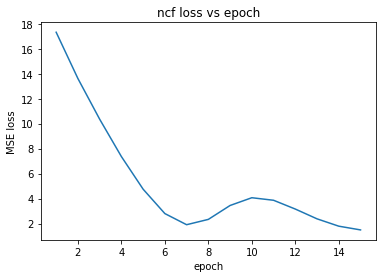

In [53]:
plt.plot(range(1, len(MSE_list) + 1),MSE_list_final)

plt.ylabel('MSE loss') #set the label for y axis
plt.xlabel('epoch') #set the label for x-axis
plt.title("ncf loss vs epoch") #set the title of the graph
plt.show() #display the graph

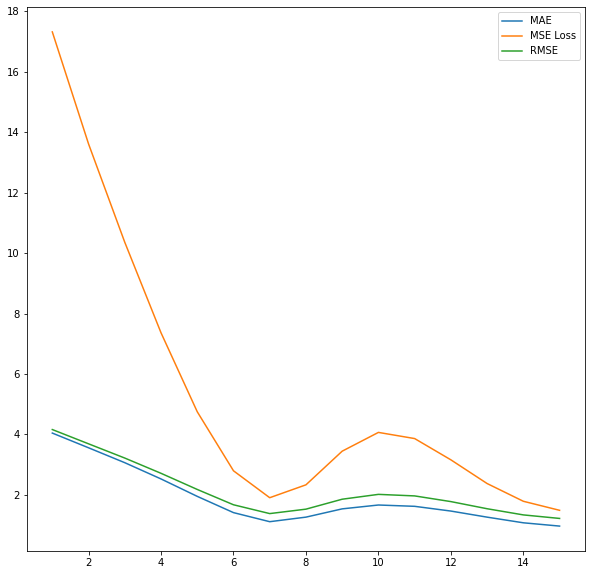

In [54]:
# MSE_list = [c.cpu().detach().numpy() for c in MSE_list]
plt.figure(figsize=(10,10))
x = list(range(1,(len(MAE_list)+1))) 
plt.plot(x,MAE_list_final,label='MAE')
plt.plot(x,MSE_list_final,label='MSE Loss')
plt.plot(x,RMSE_list_final,label='RMSE')
plt.legend()
# plt.show()
plt.savefig('ncf_64.png')